## Manifold Learning Portfolio

 


### Manifold learning

 This week's focus is on manifold learning comparing the performance of k-means and spectral clustering. Also compare PCA and t-SNE in the visualization of the result.  Here are the steps I took:

- Load the dataset to be used for the clustering analysis.
- Preprocess the dataset as needed (e.g., scale the features, normalize the data, etc.).
- Define a pipeline with preprocessing and clustering
- use PCA and t-SNE for dimension reduction and visualize the dimensions, use the clusters to color the datapoints
- use GridSearchCV to optimize the hyper parameters
- Evaluate the performance of the models using a suitable metric
- Choose the best cluster method and the best visualization method combination
- Explain choices and evaluate outcome. 

In [1]:
# Basic module imports
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans,  SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV


### LOAD DATA & DATA EXPLORATION

In [2]:
# Read the files with config yaml
def grab_config():
    with open('config.yaml', 'r') as hove:
        config = yaml.safe_load(hove)
    return config

config = grab_config()

In [3]:
# Read data
df = pd.read_csv(config['liver_data'])
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM362958.CEL.gz,HCC,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,GSM362959.CEL.gz,HCC,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,GSM362960.CEL.gz,HCC,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,GSM362964.CEL.gz,HCC,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,GSM362965.CEL.gz,HCC,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


In [214]:
# Check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Columns: 22279 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(22277), object(2)
memory usage: 60.7+ MB


In [4]:
# df dimension
df.shape

(357, 22279)

In [5]:
# Number of clusters: 2
df.type.unique()

array(['HCC', 'normal'], dtype=object)

In [215]:
# Check for empty cells
missing = df.isnull().sum()
missing[missing > 0]

# No empty cell

Series([], dtype: int64)

In [216]:
# Grab the numerical features
df_num = df.select_dtypes(include=np.number)
df_num.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,3.654116,3.804983,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,5.137159,8.622475,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,4.515175,12.681439,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,5.192624,11.759412,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,4.961625,10.318552,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


#### Check for Normality

In [217]:
# Using standard deviation

std = df_num.std()
std.min(), std.max()

# The difference in minimum and maximum std does not seem much

(0.11287475595407068, 3.338703479671072)

In [218]:
# Or using Shapiro test to check normality
stat, p = shapiro(df_num)
print(f'Stat = {stat:.3f}, P = {p:.3f}')

if p > 0.05:
    print('Data looks normally distributed')
else:
    print('Data does not look normally distributed')


Stat = 0.858, P = 0.000
Data does not look normally distributed


c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [219]:
# Check skewness
skew_columns = df_num.skew().sort_values(ascending=False)
skew_columns = skew_columns[skew_columns > 0.75]
len(skew_columns)

#About 12,256 skewed columns > 0.75

12256

In [220]:
# Using pipeline to log transformed and scale

prep = Pipeline([('log1p', FunctionTransformer(np.log1p)), 
                 ('minmaxscale', MinMaxScaler())]
               )

piped_data = prep.fit_transform(df_num)

### APPLY UNSUPERVISED LEARNING MODELS

### K-means

In [223]:
# helper function to color clusters
plt.rcParams['figure.figsize'] = [8,8]
def display_cluster(X,km,num_clusters, ax=plt):
    """
    function that plot the clusters by giving each datapoint in the cluster a color 
    and furthermore the centroid of the cluster is plotted
    parameters
    X: input matrix with features and observations
    km: fitted model with the labels for each datapoint and the centroids (km.labels_, km.centers_)
    num_clusters: the number of clusters to display
    ax: either plot or subplot location
    """
    #color = 'brgcmkyw'
    color = list(mcolors.TABLEAU_COLORS.values())
    for i in range(num_clusters):
        #plot the datapoints in the color of the label
        ax.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = 0.4, s = 10)
        #plot the centroid
        ax.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], 
                    marker = '^', s = 300, alpha = 1)

c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


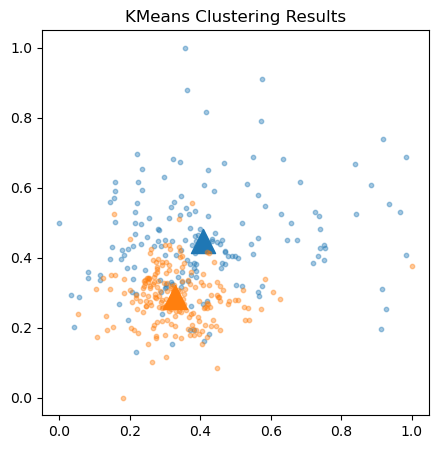

In [224]:
# Using 2 clusters on Kmeans
km = KMeans(n_clusters=2)
km = km.fit(piped_data)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(5,5))
# Call the display_cluster function
display_cluster(piped_data, km, 2, ax=ax)

# Add title to the plot
plt.title('KMeans Clustering Results');

### Spectral clustering

c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


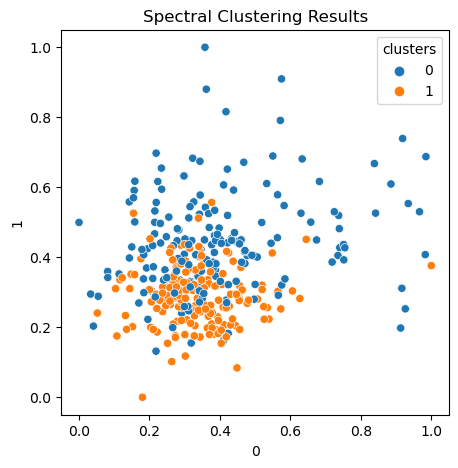

In [225]:
# Instantiate and fit model
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=10)
sc.fit(piped_data)

# Create a new figure
plt.figure(figsize=(5,5))

#plot
df = pd.DataFrame(piped_data)

df['clusters'] = sc.labels_
sns.scatterplot(data=df, x=0, y=1, hue = 'clusters')

# Add title to the plot
plt.title('Spectral Clustering Results');

From the clusterings above (Kmeans and spectral), Kmeans shows a better separation in clusters on the dataset than specteral clustering 

### DIMENSIONALITY REDUCTION

### PCA

In [226]:
# Instantiate pca
pca = PCA(n_components=10)
# Fit pca
principalComponents = pca.fit_transform(piped_data)
# Create a dataframe of PCs
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10'])

Text(0.5, 1.0, 'Explained variance (ratio)')

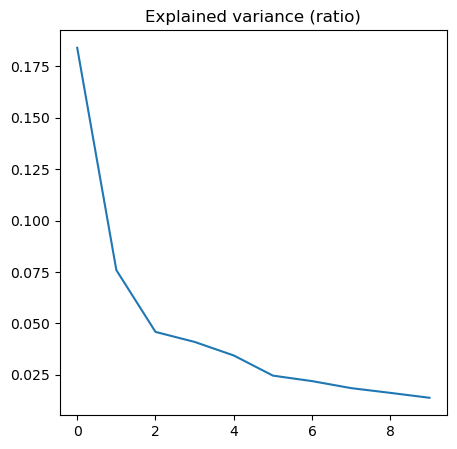

In [227]:
# Create a new figure
plt.figure(figsize=(5,5))

plt.plot(pca.explained_variance_ratio_)
plt.title('Explained variance (ratio)')

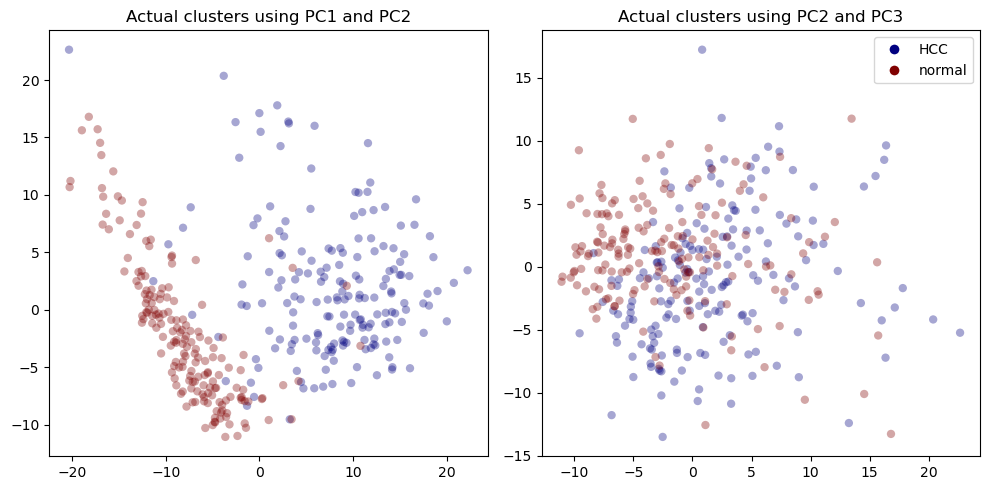

In [231]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Assign numeric values to categories
category_mapping = {'HCC': 1, 'normal': 2}
df['type_numeric'] = df['type'].map(category_mapping)

# First subplot: PC1 vs PC2
scatter1 = axs[0].scatter(principalDf['pc1'], principalDf['pc2'], c=df['type_numeric'], cmap="jet", edgecolor="None", alpha=0.35)
axs[0].set_title('Actual clusters using PC1 and PC2')

# Second subplot: PC2 vs PC3
scatter2 = axs[1].scatter(principalDf['pc2'], principalDf['pc3'], c=df['type_numeric'], cmap="jet", edgecolor="None", alpha=0.35)
axs[1].set_title('Actual clusters using PC2 and PC3')

# Create a custom legend
labels = ['HCC', 'normal']
colors = [scatter1.cmap(scatter1.norm(category_mapping[label])) for label in labels]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
                   for label, color in zip(labels, colors)]
plt.legend(handles=legend_elements, loc='best')

# Adjust spacing between subplots
plt.tight_layout()

Clustering with PC1 and PC2 show better separation

### t-SNE

In [ ]:
# Instatiate tsne
tsne = TSNE(verbose=1, perplexity=40, n_iter= 4000)
# Fit
Y = tsne.fit_transform(piped_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 357 samples in 0.130s...
[t-SNE] Computed neighbors for 357 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 357 / 357
[t-SNE] Mean sigma: 7.107348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.967426
[t-SNE] KL divergence after 1200 iterations: 0.697763


In [ ]:
# Define a function to plot tsne
def plot_data(Y, df):
    #add x, y features to the original df
    df['x'] = piped_data[:,0]
    df['y'] = piped_data[:,1]
    plt.figure(figsize=(5,5))
    sns.scatterplot(x = 'x', y = 'y', hue = 'type', data = df, alpha = 0.5, palette=['red','blue'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title('tSNE colored by actual clusters')
    plt.show()

# Inspirition from: tutorial_manifold_tSNE notebook

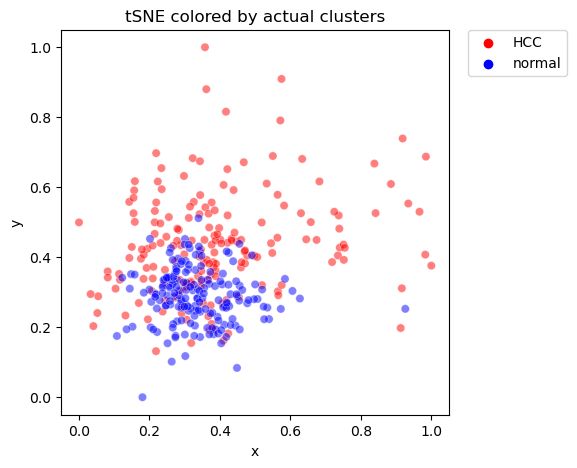

In [ ]:
# Call function
plot_data(Y, df)

tsne does not show a good separation of clusters from the above visualization

### MODEL EVALUATION

In [ ]:
# Evaluate KMeans model
kmeans = KMeans(n_clusters=2)
kmeans_labels = kmeans.fit_predict(piped_data)
kmeans_silhouette = silhouette_score(piped_data, kmeans_labels)

# Evaluate Spectral Clustering model
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=10)
spectral_labels = spectral.fit_predict(piped_data)
spectral_silhouette = silhouette_score(piped_data, spectral_labels)

# Print the silhouette scores
print("KMeans Silhouette Score:", kmeans_silhouette)
print("Spectral Clustering Silhouette Score:", spectral_silhouette)


c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans Silhouette Score: 0.1484959493319516
Spectral Clustering Silhouette Score: 0.10541339559500554


c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


The KMeans model achieved a silhouette score of approximately 0.1485, which suggests that the clusters generated by KMeans are somewhat well-separated. However, the score is not particularly high, indicating that there might be some degree of overlap between the clusters.

On the other hand, the Spectral Clustering model achieved a slightly lower silhouette score of approximately 0.1054. This score indicates that the clusters generated by Spectral Clustering may have a higher degree of overlap compared to KMeans.

### HYPERPARAMETER TUNING

In [ ]:
hyperparams = {
    'kmeans__n_clusters': [2, 3, 4, 6, 8],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__random_state': [0, 42, 100],

}

# Instantiate the KMeans object
kmeans = KMeans()

# Instantiate the Pipeline object with the StandardScaler and KMeans objects
pipeline = Pipeline([
    ('prep', prep),
    ('kmeans', kmeans)
])

# Instantiate the GridSearchCV object with the Pipeline object and parameter grid
grid_search = GridSearchCV(estimator=pipeline, param_grid=hyperparams, cv=10, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(df_num)

# Access the best combination of hyperparameters and the corresponding evaluation metric score
print(grid_search.best_params_)
print(grid_search.best_score_)


c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


{'kmeans__init': 'k-means++', 'kmeans__n_clusters': 8, 'kmeans__random_state': 0}
-16055.455714336935


### Clustering with the fine tuned hyperparameters
Except the number of clusters

c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\IHE-Sale\Desktop\Python_projects\env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when the

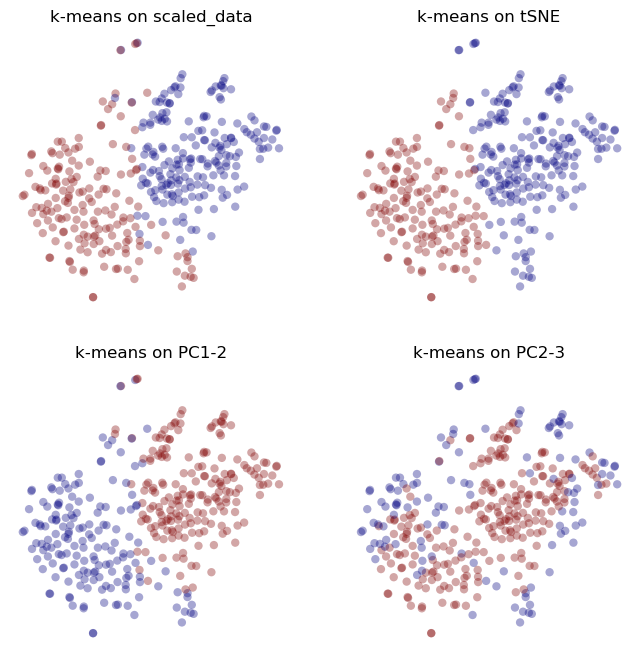

(-16.71492643356323,
 17.736584377288818,
 -12.428183126449586,
 12.345536756515504)

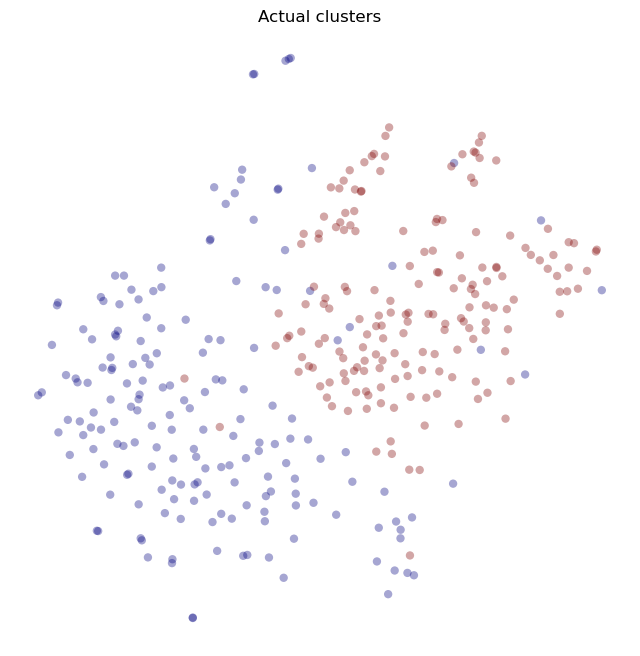

In [232]:
#Cluster using k-means

kmns = KMeans(n_clusters=2, init='k-means++', random_state=0)

# K-means on original data
kY = kmns.fit_predict(piped_data)

plt.subplot(221)
plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('k-means on scaled_data')
plt.axis('off')



# K-means on tSNE results
kY = kmns.fit_predict(Y)

plt.subplot(222)
plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('k-means on tSNE')
plt.axis('off')


# K-means on PC 1 - 2
kY = kmns.fit_predict(principalDf.iloc[:,0:1])
plt.subplot(223)
plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('k-means on PC1-2')
plt.axis('off')

# K-means on PC 2 - 3
kY = kmns.fit_predict(principalDf.iloc[:,1:2])
plt.subplot(224)
plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('k-means on PC2-3')
plt.axis('off')
plt.show()

# Actual cluster
plt.scatter(Y[:,0],Y[:,1],  c = df['type_numeric'], cmap = "jet", edgecolor = "None", alpha=0.35)
plt.title('Actual clusters')
plt.axis('off')

# Code source: E_Clustering_breast_cancer_solution.ipynb

Kmeans on tsne shows the best clusters